In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['generic_outliers_data.csv', 'delivery_related.csv', 'session_related.csv']


In [2]:
#Import Libraries
# Visual representation libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

#### 1. Load the Datasets

In [3]:
session_df = pd.read_csv('../input/session_related.csv')
delivery_df = pd.read_csv('../input/delivery_related.csv')
outlier_df = pd.read_csv('../input/generic_outliers_data.csv')

In [4]:
session_df.head()

,OrderId,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo
0,86611,57.79.00.250,211.75.38.8,431401,431401,NO
1,61343,2.8.4.8,8.9.103.186,403712,403712,NO
2,55944,5.151.253.234,5.151.253.234,793101,793101,YES
3,842,235.231.255.2,235.231.255.2,177001,176992,NO
4,50594,255.251.119.201,255.251.119.201,799201,799201,NO


In [5]:
session_df.shape,session_df.dtypes

((100000, 6), OrderId              int64
 IP_start_session    object
 IP_end_session      object
 Session_Pincode      int64
 Delivery_Pincode     int64
 IsValidGeo          object
 dtype: object)

In [6]:
delivery_df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud
0,47019,41601,41601,yes,no,yes,yes,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,yes,no,no,normal
1,20242,30352,30352,no,yes,no,no,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,yes,yes,no,normal
2,79619,12328,12328,yes,no,yes,yes,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,yes,no,yes,suspicious
3,80669,19203,19203,yes,no,yes,no,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,yes,no,yes,normal
4,64577,19842,19842,no,no,no,yes,8815,8811,17/01/2019,26/11/2018,21/01/2019,28/01/2019,yes,no,yes,normal


In [7]:
delivery_df.shape, delivery_df.dtypes

((100000, 17), CustId                  int64
 OrderId                 int64
 ProductId               int64
 IsValidAddress         object
 IsAddchangeRecently    object
 IsAddchangeonDel       object
 IsDeliveryRejected     object
 OriginalPrice           int64
 PaidPrice               int64
 OrderDate              object
 AddressChangeDate      object
 DeliveryDate           object
 ReplacementDate        object
 IsProductConsumable    object
 IsOneTimeUseProduct    object
 IsOfferCodeApplied     object
 Fraud                  object
 dtype: object)

In [8]:
outlier_df.head()

,CustId,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode
0,100,18,WCkD3InDq@gmail.com,4916661116,A7-17-AC-BB-87-09,3580,Baidyanadh Deoghar,Technical,very low,814112
1,101,18,iPjORQGqy@hotmail.com,8156912083,3D-E0-06-66-01-00,7585,Chakpirang,Non-technical,very low,795102
2,102,18,ShyCmCDbmB@aol.com,6663941231,3A-DE-69-A8-98-04,4456,Kala pahad,Non-technical,very low,795122
3,103,18,VdjRDafd@yahoo.com,3761853308,15-74-5C-91-78-E6,91474,Ukhrul,Technical,very high,795142
4,104,18,rLaKt3AxMK@gmail.com,7391938452,BA-6B-47-85-66-E7,62522,Kulittalai,Non-technical,high,639104


In [9]:
delivery_df.shape, delivery_df.dtypes

((100000, 17), CustId                  int64
 OrderId                 int64
 ProductId               int64
 IsValidAddress         object
 IsAddchangeRecently    object
 IsAddchangeonDel       object
 IsDeliveryRejected     object
 OriginalPrice           int64
 PaidPrice               int64
 OrderDate              object
 AddressChangeDate      object
 DeliveryDate           object
 ReplacementDate        object
 IsProductConsumable    object
 IsOneTimeUseProduct    object
 IsOfferCodeApplied     object
 Fraud                  object
 dtype: object)

#### Merge the three Dataframes to a single Dataframe

In [10]:
ds_merge_df = pd.merge(delivery_df,session_df,on='OrderId')

In [11]:
df = pd.merge(ds_merge_df,outlier_df,on='CustId')

In [12]:
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode
0,47019,41601,41601,yes,no,yes,yes,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,yes,no,no,normal,99.55.251.225,99.55.251.225,276001,276001,YES,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,Non-technical,very high,413512
1,20242,30352,30352,no,yes,no,no,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,yes,yes,no,normal,206.253.101.58,206.253.101.58,505468,505456,YES,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,Non-technical,very low,400001
2,79619,12328,12328,yes,no,yes,yes,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,yes,no,yes,suspicious,151.250.152.84,151.250.152.84,586209,586208,NO,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,Technical,very low,471001
3,79619,80750,80750,no,yes,no,no,2662,2662,19/01/2019,15/09/2018,26/01/2019,31/01/2019,yes,yes,yes,normal,4.255.99.237,4.255.179.19,791102,791102,NO,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,Technical,very low,471001
4,80669,19203,19203,yes,no,yes,no,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,yes,no,yes,normal,91.253.4.00,91.253.4.00,250001,249986,YES,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,Non-technical,very low,799131


In [13]:
df.shape,df.dtypes

((100000, 31), CustId                  int64
 OrderId                 int64
 ProductId               int64
 IsValidAddress         object
 IsAddchangeRecently    object
 IsAddchangeonDel       object
 IsDeliveryRejected     object
 OriginalPrice           int64
 PaidPrice               int64
 OrderDate              object
 AddressChangeDate      object
 DeliveryDate           object
 ReplacementDate        object
 IsProductConsumable    object
 IsOneTimeUseProduct    object
 IsOfferCodeApplied     object
 Fraud                  object
 IP_start_session       object
 IP_end_session         object
 Session_Pincode         int64
 Delivery_Pincode        int64
 IsValidGeo             object
 Age                     int64
 EmailId                object
 MobileNo                int64
 MacAddress             object
 AvgPurchase             int64
 City                   object
 OccupationalLevel      object
 IncomeLevel            object
 Pincode                 int64
 dtype: object)

#### Memory Usage Optimization

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [15]:
df = reduce_mem_usage(df)  

Memory usage of dataframe is 24.41 MB
Memory usage after optimization is: 20.49 MB
Decreased by 16.1%


In [16]:
df.dtypes

CustId                    int32
OrderId                   int32
ProductId                 int32
IsValidAddress         category
IsAddchangeRecently    category
IsAddchangeonDel       category
IsDeliveryRejected     category
OriginalPrice             int16
PaidPrice                 int16
OrderDate              category
AddressChangeDate      category
DeliveryDate           category
ReplacementDate        category
IsProductConsumable    category
IsOneTimeUseProduct    category
IsOfferCodeApplied     category
Fraud                  category
IP_start_session       category
IP_end_session         category
Session_Pincode           int32
Delivery_Pincode          int32
IsValidGeo             category
Age                        int8
EmailId                category
MobileNo                  int64
MacAddress             category
AvgPurchase               int32
City                   category
OccupationalLevel      category
IncomeLevel            category
Pincode                   int32
dtype: o

#### 2. Exploratory Data Analysis

In [17]:
# describe() method shows values like count, mean, standard deviation, etc. of numeric data types.
df.describe()

,CustId,OrderId,ProductId,OriginalPrice,PaidPrice,Session_Pincode,Delivery_Pincode,Age,MobileNo,AvgPurchase,Pincode
count,100000.00000,100000.000000,100000.000000,100000.00000,100000.00000,100000.00000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000
mean,50076.51905,50099.500000,50099.500000,5491.29768,5487.29895,563983.98808,563979.992390,18.705590,5.489625e+09,30194.418070,564968.183150
std,28810.89187,28867.657797,28867.657797,2593.78428,2593.78457,205918.85053,205918.834943,1.832879,2.594212e+09,30912.551998,206834.410381
min,100.00000,100.000000,100.000000,1000.00000,980.00000,121001.00000,120981.000000,18.000000,1.000380e+09,1000.000000,121001.000000
25%,25177.00000,25099.750000,25099.750000,3250.00000,3245.75000,403705.00000,403691.000000,18.000000,3.249997e+09,5524.000000,403604.000000
50%,50051.50000,50099.500000,50099.500000,5502.00000,5499.00000,585201.00000,585201.000000,18.000000,5.478894e+09,9968.000000,585401.000000
75%,75043.00000,75099.250000,75099.250000,7730.00000,7726.00000,786125.00000,786125.000000,18.000000,7.728095e+09,55079.250000,788105.000000
max,100097.00000,100099.000000,100099.000000,9999.00000,9999.00000,854301.00000,854301.000000,35.000000,9.999763e+09,99999.000000,854301.000000


In [18]:
# Get the total missing values present in columns of both train and test dataset
df.isnull().sum()

CustId                 0
OrderId                0
ProductId              0
IsValidAddress         0
IsAddchangeRecently    0
IsAddchangeonDel       0
IsDeliveryRejected     0
OriginalPrice          0
PaidPrice              0
OrderDate              0
AddressChangeDate      0
DeliveryDate           0
ReplacementDate        0
IsProductConsumable    0
IsOneTimeUseProduct    0
IsOfferCodeApplied     0
Fraud                  0
IP_start_session       0
IP_end_session         0
Session_Pincode        0
Delivery_Pincode       0
IsValidGeo             0
Age                    0
EmailId                0
MobileNo               0
MacAddress             0
AvgPurchase            0
City                   0
OccupationalLevel      0
IncomeLevel            0
Pincode                0
dtype: int64

In [19]:
# Survival rate from train data
Fraud_txn = df[df['Fraud']=='fraudulent']
normal_txn = df[df['Fraud']=='normal']
suspicious_txn = df[df['Fraud']=='suspicious']

print("---------------------------")
print("From the training dataset:")
print("---------------------------")
print("  Total Customers : %i"\
      %(len(df)))
print("")
print("  Total Normal transactions  : %i"\
      %(len(normal_txn)))

print("  Normal transactions Rate   : %i %% "\
     % (1.*len(normal_txn)/len(df)*100.0))
print("-------------------------")

print("  Fraudulent transactions         : %i"\
      %(len(Fraud_txn)))

print("  Fraudulent transactions Rate    : %i %% "\
     % (1.*len(Fraud_txn)/len(df)*100.0))
print("-------------------------")

print("  Suspicious transactions         : %i"\
      %(len(suspicious_txn)))

print("  Suspicious transactions Rate    : %i %% "\
     % (1.*len(suspicious_txn)/len(df)*100.0))

---------------------------
From the training dataset:
---------------------------
  Total Customers : 100000

  Total Normal transactions  : 70000
  Normal transactions Rate   : 70 % 
-------------------------
  Fraudulent transactions         : 5000
  Fraudulent transactions Rate    : 5 % 
-------------------------
  Suspicious transactions         : 25000
  Suspicious transactions Rate    : 25 % 


**Observations:**

From the dataset we get to know the below details:
* There is no missing data.
* Out of 100000 customers, 70% of the transactions are normal.
* 25% of them suspicious transactions.
* 5% are fraudulent transactions.

For the next step we will try to **visualize the data.**

Visualizing the data helps us understanding the data better and this will help us in getting the dataset well prepared for the Model training.

#### Data Visualization

Below is the function **"bar_chart"** which will take in a feature as a parameter and provide us the bar chart.

The Bar chart will show how the **transaction type** varies with different features and its subtypes.

In [20]:
def bar_chart(feature):
    normal = df[df['Fraud']=='normal'][feature].value_counts()
    suspicious = df[df['Fraud']=='suspicious'][feature].value_counts()      
    Fraud = df[df['Fraud']=='fraudulent'][feature].value_counts()
    bar_df = pd.DataFrame([normal,suspicious,Fraud])
    bar_df.index = ['Normal','Suspicious','Fraudulent']
    bar_df.plot(kind='bar',stacked=True, figsize=(7,5))

#### Relationship between Features and Target Variable
Now in the below section we are going to see how each features impacts the transaction type of a customer.

In [21]:
def feature_relationship(feature):
    print(df[feature].value_counts())
    print('--------------------------------------')
    print(df.groupby(feature).Fraud.value_counts())
    bar_chart(feature)
    

no     50010
yes    49990
Name: IsValidAddress, dtype: int64
--------------------------------------
IsValidAddress  Fraud     
no              normal        34802
                suspicious    12660
                fraudulent     2548
yes             normal        35198
                suspicious    12340
                fraudulent     2452
Name: Fraud, dtype: int64


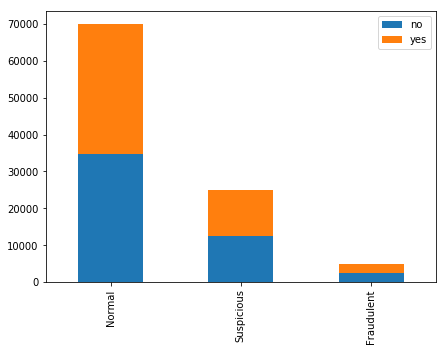

In [22]:
feature_relationship('IsValidAddress')

no     50047
yes    49953
Name: IsAddchangeRecently, dtype: int64
--------------------------------------
IsAddchangeRecently  Fraud     
no                   normal        35211
                     suspicious    12374
                     fraudulent     2462
yes                  normal        34789
                     suspicious    12626
                     fraudulent     2538
Name: Fraud, dtype: int64


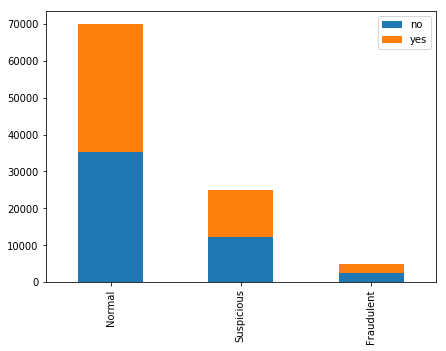

In [23]:
feature_relationship('IsAddchangeRecently')

no     50061
yes    49939
Name: IsAddchangeonDel, dtype: int64
--------------------------------------
IsAddchangeonDel  Fraud     
no                normal        35045
                  suspicious    12537
                  fraudulent     2479
yes               normal        34955
                  suspicious    12463
                  fraudulent     2521
Name: Fraud, dtype: int64


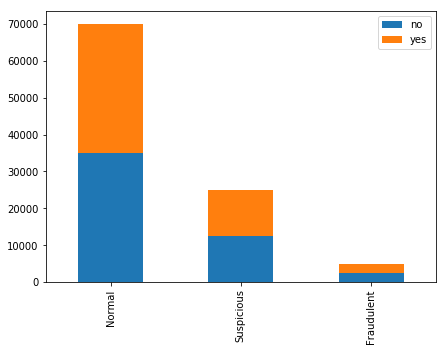

In [24]:
feature_relationship('IsAddchangeonDel')

yes    50154
no     49846
Name: IsDeliveryRejected, dtype: int64
--------------------------------------
IsDeliveryRejected  Fraud     
no                  normal        34838
                    suspicious    12488
                    fraudulent     2520
yes                 normal        35162
                    suspicious    12512
                    fraudulent     2480
Name: Fraud, dtype: int64


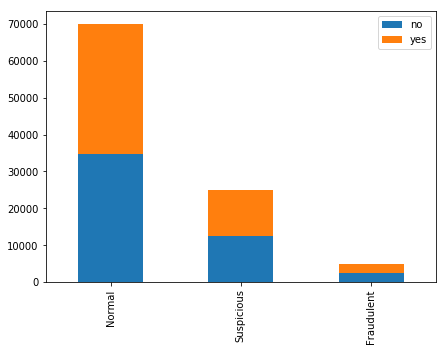

In [25]:
feature_relationship('IsDeliveryRejected') 

no     50109
yes    49891
Name: IsProductConsumable, dtype: int64
--------------------------------------
IsProductConsumable  Fraud     
no                   normal        35024
                     suspicious    12553
                     fraudulent     2532
yes                  normal        34976
                     suspicious    12447
                     fraudulent     2468
Name: Fraud, dtype: int64


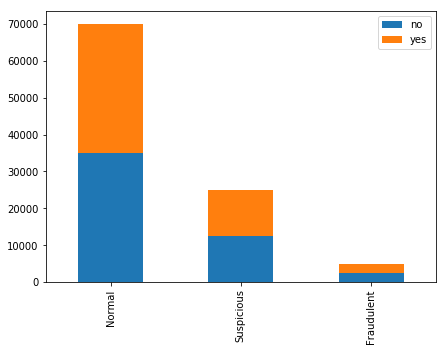

In [26]:
feature_relationship('IsProductConsumable')

no     50033
yes    49967
Name: IsOneTimeUseProduct, dtype: int64
--------------------------------------
IsOneTimeUseProduct  Fraud     
no                   normal        34963
                     suspicious    12498
                     fraudulent     2572
yes                  normal        35037
                     suspicious    12502
                     fraudulent     2428
Name: Fraud, dtype: int64


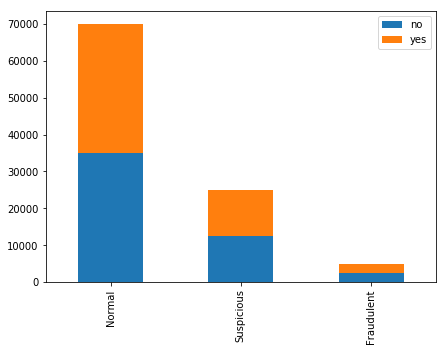

In [27]:
feature_relationship('IsOneTimeUseProduct')

no     50008
yes    49992
Name: IsOfferCodeApplied, dtype: int64
--------------------------------------
IsOfferCodeApplied  Fraud     
no                  normal        35080
                    suspicious    12493
                    fraudulent     2435
yes                 normal        34920
                    suspicious    12507
                    fraudulent     2565
Name: Fraud, dtype: int64


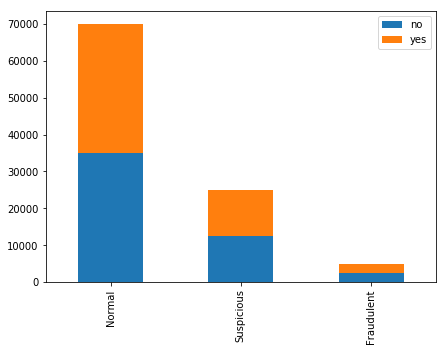

In [28]:
feature_relationship('IsOfferCodeApplied')

YES    50162
NO     49838
Name: IsValidGeo, dtype: int64
--------------------------------------
IsValidGeo  Fraud     
NO          normal        34800
            suspicious    12538
            fraudulent     2500
YES         normal        35200
            suspicious    12462
            fraudulent     2500
Name: Fraud, dtype: int64


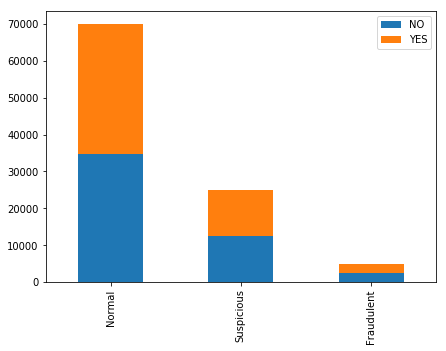

In [29]:
feature_relationship('IsValidGeo')

Non-technical    50296
Technical        49704
Name: OccupationalLevel, dtype: int64
--------------------------------------
OccupationalLevel  Fraud     
Non-technical      normal        35139
                   suspicious    12632
                   fraudulent     2525
Technical          normal        34861
                   suspicious    12368
                   fraudulent     2475
Name: Fraud, dtype: int64


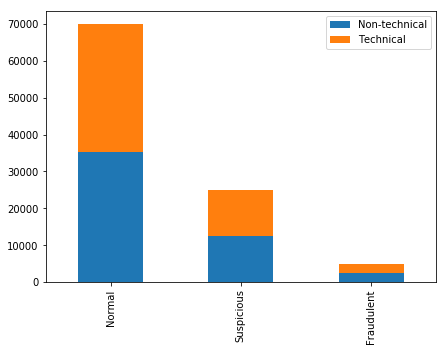

In [30]:
feature_relationship('OccupationalLevel')

very low     44617
moderate     15830
very high    15289
high         13431
low          10833
Name: IncomeLevel, dtype: int64
--------------------------------------
IncomeLevel  Fraud     
high         normal         9449
             suspicious     3318
             fraudulent      664
low          normal         7580
             suspicious     2686
             fraudulent      567
moderate     normal        11030
             suspicious     4012
             fraudulent      788
very high    normal        10678
             suspicious     3836
             fraudulent      775
very low     normal        31263
             suspicious    11148
             fraudulent     2206
Name: Fraud, dtype: int64


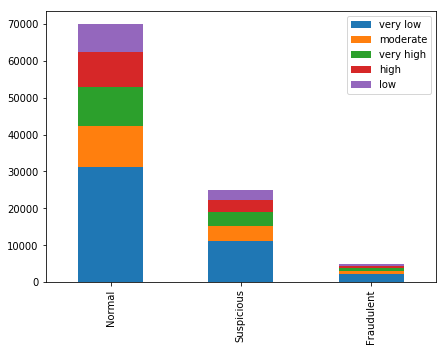

In [31]:
feature_relationship('IncomeLevel')

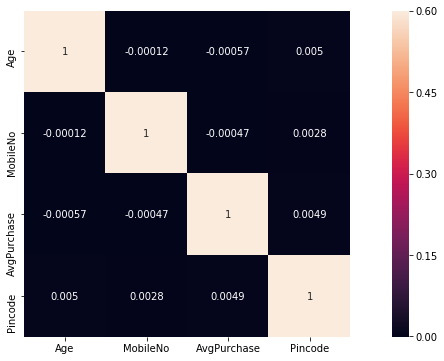

In [32]:
#Correlating Features
drop_features = ['CustId','OrderId','ProductId','OriginalPrice','PaidPrice','Session_Pincode','Delivery_Pincode']
plt.figure(figsize=(15,6))
sns.heatmap(df.drop(drop_features,axis=1).corr(), vmax=0.6, square=True, annot=True)

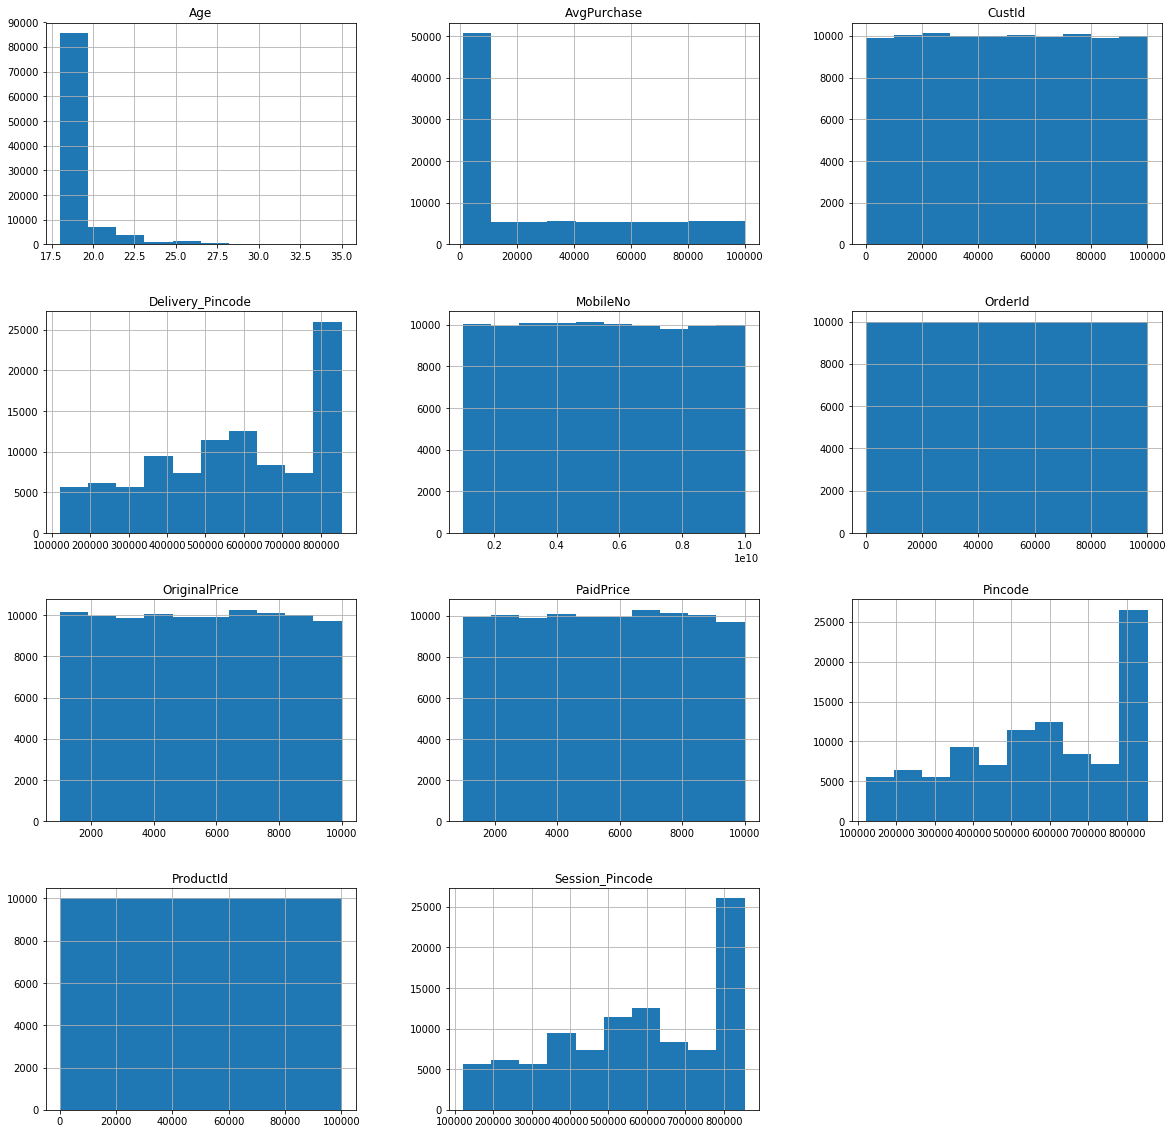

In [33]:
# print histogram for each parameter
df.hist(figsize=(20,20))
plt.show()

In [34]:
from sklearn.preprocessing import LabelEncoder
categorical = ['IsValidAddress','IsAddchangeRecently','IsAddchangeonDel','IsDeliveryRejected','IsProductConsumable','IsOneTimeUseProduct','IsOfferCodeApplied','IsValidGeo','OccupationalLevel','IncomeLevel']

label_encoder = LabelEncoder()
for col in categorical:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df=df.iloc[:df.shape[0]]

Fraud
fraudulent    AxesSubplot(0.125,0.125;0.775x0.755)
normal        AxesSubplot(0.125,0.125;0.775x0.755)
suspicious    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

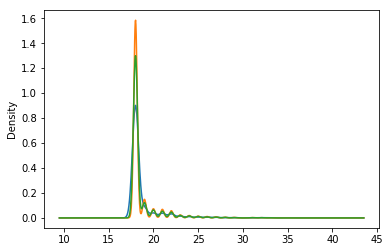

In [35]:
df.groupby('Fraud').Age.plot(kind='kde')

Fraud
fraudulent    AxesSubplot(0.125,0.125;0.775x0.755)
normal        AxesSubplot(0.125,0.125;0.775x0.755)
suspicious    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

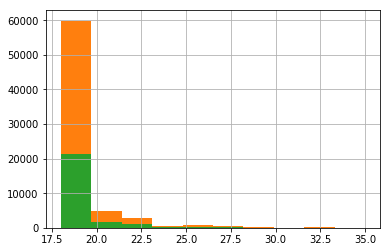

In [36]:
df.groupby('Fraud').Age.hist()

In [37]:
df['AgeGroup'] = pd.cut(df['Age'], [10,15,18,21,24,27,30,33,35,40,50,100],
                            labels=['0', '1', '2','3','4','5','6','7','8','9','10'])
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup
0,47019,41601,41601,1,0,1,1,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,1,0,0,normal,99.55.251.225,99.55.251.225,276001,276001,1,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3
1,20242,30352,30352,0,1,0,0,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,1,1,0,normal,206.253.101.58,206.253.101.58,505468,505456,1,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1
2,79619,12328,12328,1,0,1,1,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,1,0,1,suspicious,151.250.152.84,151.250.152.84,586209,586208,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1
3,79619,80750,80750,0,1,0,0,2662,2662,19/01/2019,15/09/2018,26/01/2019,31/01/2019,1,1,1,normal,4.255.99.237,4.255.179.19,791102,791102,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1
4,80669,19203,19203,1,0,1,0,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,1,0,1,normal,91.253.4.00,91.253.4.00,250001,249986,1,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1


In [38]:
df['domain'] = df['EmailId'].str.split('@').str[1]
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain
0,47019,41601,41601,1,0,1,1,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,1,0,0,normal,99.55.251.225,99.55.251.225,276001,276001,1,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3,yahoo.com
1,20242,30352,30352,0,1,0,0,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,1,1,0,normal,206.253.101.58,206.253.101.58,505468,505456,1,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1,hotmail.com
2,79619,12328,12328,1,0,1,1,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,1,0,1,suspicious,151.250.152.84,151.250.152.84,586209,586208,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com
3,79619,80750,80750,0,1,0,0,2662,2662,19/01/2019,15/09/2018,26/01/2019,31/01/2019,1,1,1,normal,4.255.99.237,4.255.179.19,791102,791102,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com
4,80669,19203,19203,1,0,1,0,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,1,0,1,normal,91.253.4.00,91.253.4.00,250001,249986,1,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1,gmail.com


In [39]:
df.domain.unique()

array(['yahoo.com', 'hotmail.com', 'gmail.com', 'aol.com', 'mail.com'],
      dtype=object)

hotmail.com    20174
mail.com       20117
yahoo.com      20054
gmail.com      19860
aol.com        19795
Name: domain, dtype: int64
--------------------------------------
domain       Fraud     
aol.com      normal        13852
             suspicious     4903
             fraudulent     1040
gmail.com    normal        13850
             suspicious     5044
             fraudulent      966
hotmail.com  normal        14097
             suspicious     5075
             fraudulent     1002
mail.com     normal        14121
             suspicious     5027
             fraudulent      969
yahoo.com    normal        14080
             suspicious     4951
             fraudulent     1023
Name: Fraud, dtype: int64


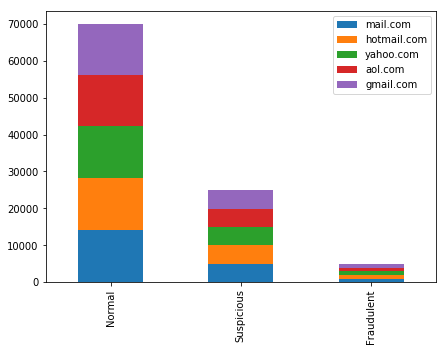

In [40]:
feature_relationship('domain')

In [41]:
def ip_to_int(ip_ser):
    ips = ip_ser.str.split('.', expand=True).astype(np.int16).values
    mults = np.tile(np.array([24, 16, 8, 0]), len(ip_ser)).reshape(ips.shape)
    return np.sum(np.left_shift(ips, mults), axis=1)

In [42]:
df['_IP_start_session'] = ip_to_int(df.IP_start_session)
df['_IP_end_session'] = ip_to_int(df.IP_end_session)
df.head()


,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain,_IP_start_session,_IP_end_session
0,47019,41601,41601,1,0,1,1,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,1,0,0,normal,99.55.251.225,99.55.251.225,276001,276001,1,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3,yahoo.com,1664613345,1664613345
1,20242,30352,30352,0,1,0,0,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,1,1,0,normal,206.253.101.58,206.253.101.58,505468,505456,1,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1,hotmail.com,3472713018,3472713018
2,79619,12328,12328,1,0,1,1,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,1,0,1,suspicious,151.250.152.84,151.250.152.84,586209,586208,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,2549782612,2549782612
3,79619,80750,80750,0,1,0,0,2662,2662,19/01/2019,15/09/2018,26/01/2019,31/01/2019,1,1,1,normal,4.255.99.237,4.255.179.19,791102,791102,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,83846125,83866387
4,80669,19203,19203,1,0,1,0,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,1,0,1,normal,91.253.4.00,91.253.4.00,250001,249986,1,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1,gmail.com,1543308288,1543308288


In [43]:
df['OrderDate'] =  pd.to_datetime(df['OrderDate'],format='%d/%m/%Y')
df['AddressChangeDate'] =  pd.to_datetime(df['AddressChangeDate'],format='%d/%m/%Y')
df['DeliveryDate'] =  pd.to_datetime(df['DeliveryDate'],format='%d/%m/%Y')
df['ReplacementDate'] =  pd.to_datetime(df['ReplacementDate'],format='%d/%m/%Y')
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain,_IP_start_session,_IP_end_session
0,47019,41601,41601,1,0,1,1,2711,2711,2019-01-25,2018-11-20,2019-01-28,2019-02-01,1,0,0,normal,99.55.251.225,99.55.251.225,276001,276001,1,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3,yahoo.com,1664613345,1664613345
1,20242,30352,30352,0,1,0,0,2713,2710,2019-02-06,2019-02-03,2019-02-10,2019-02-17,1,1,0,normal,206.253.101.58,206.253.101.58,505468,505456,1,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1,hotmail.com,3472713018,3472713018
2,79619,12328,12328,1,0,1,1,4146,4142,2019-01-12,2018-07-30,2019-01-22,2019-02-01,1,0,1,suspicious,151.250.152.84,151.250.152.84,586209,586208,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,2549782612,2549782612
3,79619,80750,80750,0,1,0,0,2662,2662,2019-01-19,2018-09-15,2019-01-26,2019-01-31,1,1,1,normal,4.255.99.237,4.255.179.19,791102,791102,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,83846125,83866387
4,80669,19203,19203,1,0,1,0,2709,2707,2019-03-27,2018-06-14,2019-04-03,2019-04-06,1,0,1,normal,91.253.4.00,91.253.4.00,250001,249986,1,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1,gmail.com,1543308288,1543308288


In [44]:
def extract_date(df,column):
    df[column+"_year"] = df[column].apply(lambda x: x.year) 
    df[column+"_month"] = df[column].apply(lambda x: x.month)
    df[column+"_date"] = df[column].apply(lambda x: x.day)    

In [45]:
extract_date(df,'OrderDate')
extract_date(df,'AddressChangeDate')
extract_date(df,'DeliveryDate')
extract_date(df,'ReplacementDate')
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain,_IP_start_session,_IP_end_session,OrderDate_year,OrderDate_month,OrderDate_date,AddressChangeDate_year,AddressChangeDate_month,AddressChangeDate_date,DeliveryDate_year,DeliveryDate_month,DeliveryDate_date,ReplacementDate_year,ReplacementDate_month,ReplacementDate_date
0,47019,41601,41601,1,0,1,1,2711,2711,2019-01-25,2018-11-20,2019-01-28,2019-02-01,1,0,0,normal,99.55.251.225,99.55.251.225,276001,276001,1,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3,yahoo.com,1664613345,1664613345,2019,1,25,2018,11,20,2019,1,28,2019,2,1
1,20242,30352,30352,0,1,0,0,2713,2710,2019-02-06,2019-02-03,2019-02-10,2019-02-17,1,1,0,normal,206.253.101.58,206.253.101.58,505468,505456,1,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1,hotmail.com,3472713018,3472713018,2019,2,6,2019,2,3,2019,2,10,2019,2,17
2,79619,12328,12328,1,0,1,1,4146,4142,2019-01-12,2018-07-30,2019-01-22,2019-02-01,1,0,1,suspicious,151.250.152.84,151.250.152.84,586209,586208,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,2549782612,2549782612,2019,1,12,2018,7,30,2019,1,22,2019,2,1
3,79619,80750,80750,0,1,0,0,2662,2662,2019-01-19,2018-09-15,2019-01-26,2019-01-31,1,1,1,normal,4.255.99.237,4.255.179.19,791102,791102,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,83846125,83866387,2019,1,19,2018,9,15,2019,1,26,2019,1,31
4,80669,19203,19203,1,0,1,0,2709,2707,2019-03-27,2018-06-14,2019-04-03,2019-04-06,1,0,1,normal,91.253.4.00,91.253.4.00,250001,249986,1,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1,gmail.com,1543308288,1543308288,2019,3,27,2018,6,14,2019,4,3,2019,4,6


In [46]:
df.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain,_IP_start_session,_IP_end_session,OrderDate_year,OrderDate_month,OrderDate_date,AddressChangeDate_year,AddressChangeDate_month,AddressChangeDate_date,DeliveryDate_year,DeliveryDate_month,DeliveryDate_date,ReplacementDate_year,ReplacementDate_month,ReplacementDate_date
0,47019,41601,41601,1,0,1,1,2711,2711,2019-01-25,2018-11-20,2019-01-28,2019-02-01,1,0,0,normal,99.55.251.225,99.55.251.225,276001,276001,1,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,0,3,413512,3,yahoo.com,1664613345,1664613345,2019,1,25,2018,11,20,2019,1,28,2019,2,1
1,20242,30352,30352,0,1,0,0,2713,2710,2019-02-06,2019-02-03,2019-02-10,2019-02-17,1,1,0,normal,206.253.101.58,206.253.101.58,505468,505456,1,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,0,4,400001,1,hotmail.com,3472713018,3472713018,2019,2,6,2019,2,3,2019,2,10,2019,2,17
2,79619,12328,12328,1,0,1,1,4146,4142,2019-01-12,2018-07-30,2019-01-22,2019-02-01,1,0,1,suspicious,151.250.152.84,151.250.152.84,586209,586208,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,2549782612,2549782612,2019,1,12,2018,7,30,2019,1,22,2019,2,1
3,79619,80750,80750,0,1,0,0,2662,2662,2019-01-19,2018-09-15,2019-01-26,2019-01-31,1,1,1,normal,4.255.99.237,4.255.179.19,791102,791102,0,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,1,4,471001,1,gmail.com,83846125,83866387,2019,1,19,2018,9,15,2019,1,26,2019,1,31
4,80669,19203,19203,1,0,1,0,2709,2707,2019-03-27,2018-06-14,2019-04-03,2019-04-06,1,0,1,normal,91.253.4.00,91.253.4.00,250001,249986,1,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,0,4,799131,1,gmail.com,1543308288,1543308288,2019,3,27,2018,6,14,2019,4,3,2019,4,6


In [52]:
# delete unnecessary feature from dataset

print("Before", df.shape)
features_drop = ['Age','EmailId', 'MobileNo','MacAddress', 'IP_start_session', 'IP_end_session',
                'City','CustId','OrderId','ProductId','OrderDate', 'AddressChangeDate','DeliveryDate',
                'ReplacementDate']
train_data = df.drop(features_drop, axis=1)
labels = train_data['Fraud']
features = train_data.drop('Fraud', axis=1)
print("After",train_data.shape)

Before (100000, 47)
After (100000, 33)


In [53]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
features = features.apply(LabelEncoder().fit_transform)
features.head()

,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Session_Pincode,Delivery_Pincode,IsValidGeo,AvgPurchase,OccupationalLevel,IncomeLevel,Pincode,AgeGroup,domain,_IP_start_session,_IP_end_session,OrderDate_year,OrderDate_month,OrderDate_date,AddressChangeDate_year,AddressChangeDate_month,AddressChangeDate_date,DeliveryDate_year,DeliveryDate_month,DeliveryDate_date,ReplacementDate_year,ReplacementDate_month,ReplacementDate_date
0,1,0,1,1,1711,1728,1,0,0,134,2227,1,35167,0,3,271,2,4,39885,39924,0,0,24,0,10,19,0,0,27,0,1,0
1,0,1,0,0,1713,1727,1,1,0,383,6001,1,2422,0,4,226,0,2,62936,62947,0,1,5,1,1,2,0,1,9,0,1,16
2,1,0,1,1,3146,3159,1,0,1,522,8292,0,4133,1,4,328,0,1,50449,50462,0,0,11,0,6,29,0,0,21,0,1,0
3,0,1,0,0,1662,1679,1,1,1,787,12365,0,4133,1,4,328,0,1,10848,10954,0,0,18,0,8,14,0,0,25,0,0,30
4,1,0,1,0,1709,1724,1,0,1,112,1848,1,3836,0,4,944,0,1,38493,38538,0,2,26,0,5,13,0,3,2,0,3,5


In [54]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(labels)
labels_enc = encoder.transform(labels)

In [59]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(features)
train_df = pca.transform(features)


In [60]:
train_df

array([[-1.47567089e+00,  1.59235616e+00,  1.63578960e+00, ...,
        -3.84292267e-17,  3.26491745e-23, -1.32229397e-16],
       [ 5.19968787e-02,  1.64487009e+00,  5.63955190e-01, ...,
         1.50105342e-16, -2.34422575e-21, -3.54721406e-17],
       [-1.54865129e+00,  7.23738705e-01, -2.00358361e-01, ...,
        -1.79748702e-16,  1.98219063e-21, -1.81612458e-17],
       ...,
       [ 1.85884530e+00, -1.00197041e+00, -1.61988421e+00, ...,
         9.69466555e-17,  7.73672564e-23, -8.24837687e-18],
       [ 1.47561753e+00,  1.78522414e-01, -1.82098815e+00, ...,
         7.31213630e-18,  3.82478454e-21,  1.44308382e-16],
       [ 1.26512385e-02,  4.50919325e-01,  2.33764569e+00, ...,
         1.65885056e-16, -9.24895998e-21,  6.23706306e-18]])

In [61]:
from sklearn.model_selection import train_test_split
train, test, labels_train, labels_test = train_test_split(train_df, labels_enc, test_size=0.20, random_state = 42)

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, labels_train, test_size=0.30, random_state = 42)

In [65]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((56000, 32), (24000, 32), (56000,), (24000,))

## SVM Hyperparameter tuning



In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,n_jobs=-1,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for precision



In [ ]:
clf.best_params_